In [1]:
! nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import lovely_tensors as lt
lt.monkey_patch()

# Orthonorm init code is taked from Lasagne
# https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
def svd_orthonormal(w):
    shape = w.shape
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)#w;
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    # print (shape, flat_shape)
    q = q.reshape(shape)
    return q.astype(np.float32)


def orthogonal_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
        else:
            #nn.init.orthogonal(m.weight)
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            #print w_ortho 
            #m.weight.data.copy_(torch.from_numpy(w_ortho))
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
    return

In [5]:
# ! pip install lovely-tensors

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, h_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, h_size, 3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(4),

            nn.Conv2d(h_size, 16, 3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.net(x)
        return x

# Set device
device = 'cuda:1'

In [7]:
batch_size = 64
import math

In [8]:
# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)

# Initialize network, loss function and optimizer
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

# Training function
def train(net, dataloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader, 0), total = math.ceil(len(trainset)/batch_size))
    losses = []
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'l={loss.item():.5f}')

        losses.append(loss.item())

    return losses

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Validation function
def validate(net, dataloader, criterion, device):
    net.eval()
    losses = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())

    return losses

In [10]:
import lovely_tensors as lt
lt.monkey_patch()

In [11]:
def m11_to_01(t):
    return (t+1.)/2

In [12]:
# m11_to_01(inputs)[:10].rgb

In [13]:
from tqdm.auto import tqdm

In [14]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [15]:
# Training and validation loop

def train_net(net, num_epochs = 1):
    train_losses = []
    val_losses = []

    net.train()
    net = net.to(device)

    count_parameters(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net.parameters(), lr=0.001)

    for epoch in tqdm ( list ( range(num_epochs) ) ):
        train_losses_e = train(net, trainloader, criterion, optimizer, device)
        val_losses_e = validate(net, testloader, criterion, device)
        train_losses += train_losses_e
        val_losses += val_losses_e
        # print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot loss curves
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test function
    def test(net, dataloader, device):
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in dataloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    # Report final accuracy
    accuracy = test(net, testloader, device)
    print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

In [16]:
class CNNSplit(nn.Module):
    def __init__(self, h_size=16):
        super().__init__()

        self.conv1 = nn.Conv2d(3, h_size, 3)
        self.conv2 = nn.Conv2d(h_size//4, 16, 3)
        self.linear = nn.Linear(100, 10)
        self.h_size = h_size

    def forward(self, x):
        p = self.conv1(x)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()

        a = nn.MaxPool2d(4)(10*a)

        p = self.conv2(a)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
        x = nn.Flatten()(10*a)
        
        x = self.linear(x)
        return x
    
    
def lsuv_init_2layer_split_cnn(self, x, verbose = True):
    p = self.conv1(x)
    pt, ps, pcos, psin = p.chunk(4, dim=1)

    layer = self.conv1
    shape = p.shape[1]//4
    for i, preact in enumerate([pt, ps, pcos, psin]):
        if verbose:
            print('Initial preact:', preact)
        from_i, to_i = i*shape, (i+1)*shape
        # W = layer.linear.weight.data[]

        mean = preact.mean().item()
        std = preact.std().item()

        layer.bias.data[from_i:to_i] -= mean
        layer.weight.data[from_i:to_i] /= std

    p = self.conv1(x)
    pt, ps, pcos, psin = p.chunk(4, dim=1)

    for i, preact in enumerate([pt, ps, pcos, psin]):
        if verbose:
            print('after:', preact)


    a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
    a = nn.MaxPool2d(4)(10*a)


    p = self.conv2(a)
    pt, ps, pcos, psin = p.chunk(4, dim=1)
    
    print('*'*100)

    layer = self.conv2
    shape = p.shape[1]//4

    for i, preact in enumerate([pt, ps, pcos, psin]):
        if verbose:
            print('Initial preact:', preact)
        from_i, to_i = i*shape, (i+1)*shape
        # W = layer.linear.weight.data[]

        mean = preact.mean().item()
        std = preact.std().item()

        layer.bias.data[from_i:to_i] -= mean
        layer.weight.data[from_i:to_i] /= std

    p = self.conv2(a)
    pt, ps, pcos, psin = p.chunk(4, dim=1)

    for i, preact in enumerate([pt, ps, pcos, psin]):
        if verbose:
            print('after:', preact)

    a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
    x = nn.Flatten()(10*a)

    x = self.linear(x)
    return self

In [17]:
for batch in trainloader:
    x = batch[0]
    break

In [62]:
class Conv2dSplit(nn.Module):
    def __init__(self, in_size=3, out_size=32):
        super().__init__()
        self.conv = nn.Conv2d(in_size, out_size*4, 3)


    def forward(self, x):
        p = self.conv(x)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
        return a * 10


class BigCNNSplitBlock(nn.Module):
    def __init__(self, in_size=3, h_size=32, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            Conv2dSplit(in_size, h_size),
            Conv2dSplit(h_size, h_size),
            nn.MaxPool2d(2),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [63]:
class BigCNNBlock(nn.Module):
    def __init__(self, in_size=3, h_size=32, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_size, h_size, 3),
            nn.LeakyReLU(0.1),
            nn.Conv2d(h_size, h_size, 3),       
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [87]:
net = nn.Sequential(
    BigCNNSplitBlock(3, 32),
    BigCNNSplitBlock(32, 50),
    # BigCNNBlock(64, 128),

    nn.Flatten(),
    nn.Linear(1250, 10)
)

print(count_parameters(net))
net(x)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| 0.net.0.conv.weight |    3456    |
|  0.net.0.conv.bias  |    128     |
| 0.net.1.conv.weight |   36864    |
|  0.net.1.conv.bias  |    128     |
| 1.net.0.conv.weight |   57600    |
|  1.net.0.conv.bias  |    200     |
| 1.net.1.conv.weight |   90000    |
|  1.net.1.conv.bias  |    200     |
|       3.weight      |   12500    |
|        3.bias       |     10     |
+---------------------+------------+
Total Trainable Params: 201086
201086


tensor[64, 10] n=640 (2.5Kb) x∈[-0.712, 1.319] μ=0.019 σ=0.161 grad AddmmBackward0

In [59]:
p = net[0].net[0].conv(x)

# p = self.conv(x)
pt, ps, pcos, psin = p.chunk(4, dim=1)
a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()

In [88]:
# Define the CNN architecture
class BigCNN(nn.Module):
    def __init__(self, h_size=32):
        super().__init__()
        self.net = nn.Sequential(
            BigCNNBlock(3, 64),
            BigCNNBlock(64, 128),
            # BigCNNBlock(64, 128),
        
            nn.Flatten(),
            nn.Linear(3200, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x


# Define the CNN architecture
class BigCNNSplit(nn.Module):
    def __init__(self, h_size=32):
        super().__init__()
        self.net = nn.Sequential(
            BigCNNSplitBlock(3, 32),
            BigCNNSplitBlock(32, 50),
            # BigCNNBlock(64, 128),
        
            nn.Flatten(),
            nn.Linear(1250, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [89]:
x

tensor[64, 3, 32, 32] n=196608 (0.8Mb) x∈[-1.000, 1.000] μ=-0.003 σ=0.498

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
| net.0.net.0.conv.weight |    3456    |
|  net.0.net.0.conv.bias  |    128     |
| net.0.net.1.conv.weight |   36864    |
|  net.0.net.1.conv.bias  |    128     |
| net.1.net.0.conv.weight |   57600    |
|  net.1.net.0.conv.bias  |    200     |
| net.1.net.1.conv.weight |   90000    |
|  net.1.net.1.conv.bias  |    200     |
|       net.3.weight      |   12500    |
|        net.3.bias       |     10     |
+-------------------------+------------+
Total Trainable Params: 201086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.20s/it]


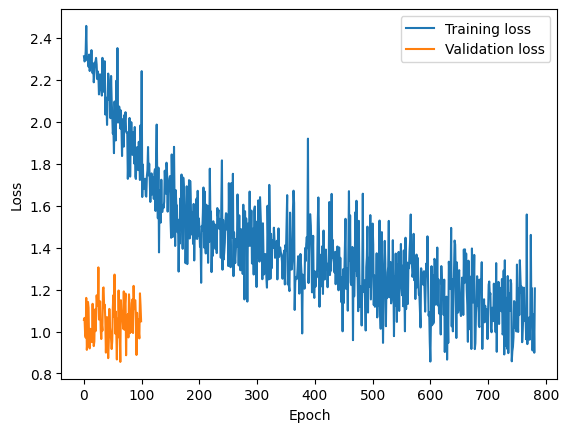

Final Test Accuracy: 62.78%


In [90]:
train_net(BigCNNSplit())

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| net.0.net.0.weight |    1728    |
|  net.0.net.0.bias  |     64     |
| net.0.net.2.weight |   36864    |
|  net.0.net.2.bias  |     64     |
| net.1.net.0.weight |   73728    |
|  net.1.net.0.bias  |    128     |
| net.1.net.2.weight |   147456   |
|  net.1.net.2.bias  |    128     |
|    net.3.weight    |   32000    |
|     net.3.bias     |     10     |
+--------------------+------------+
Total Trainable Params: 292170


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.46s/it]


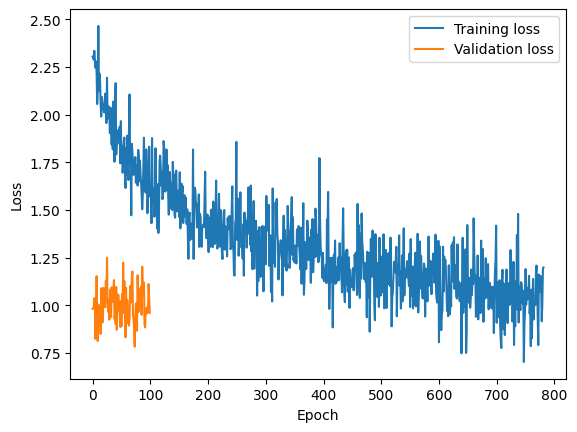

Final Test Accuracy: 65.45%


In [46]:
train_net(BigCNN())

In [ ]:
break

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    432     |
|  net.0.bias  |     16     |
| net.3.weight |    2304    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 3418


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

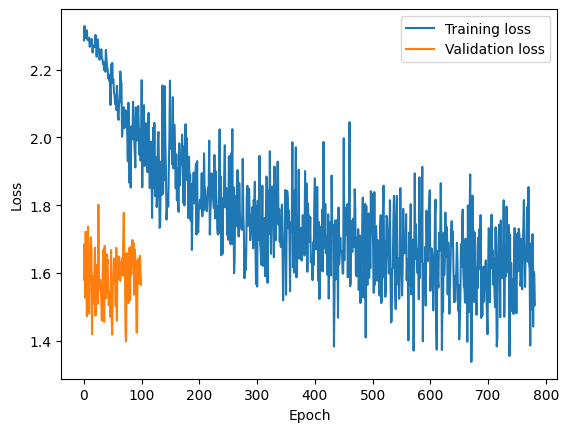

Final Test Accuracy: 43.28%


In [39]:
train_net(CNN(h_size=16))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    864     |
|  net.0.bias  |     32     |
| net.3.weight |    4608    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 6170


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

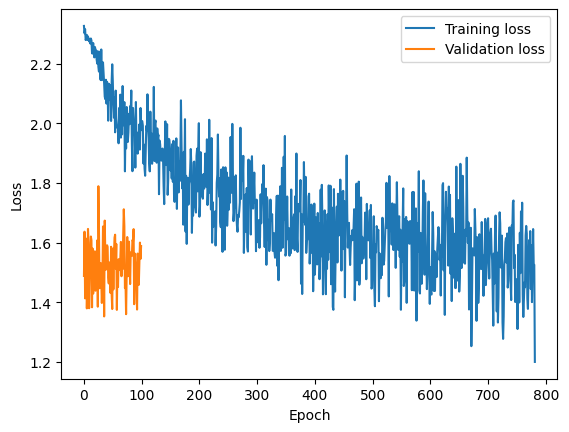

Final Test Accuracy: 44.45%


In [38]:
train_net(CNN(h_size=32))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    1728    |
|  net.0.bias  |     64     |
| net.3.weight |    9216    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 11674


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

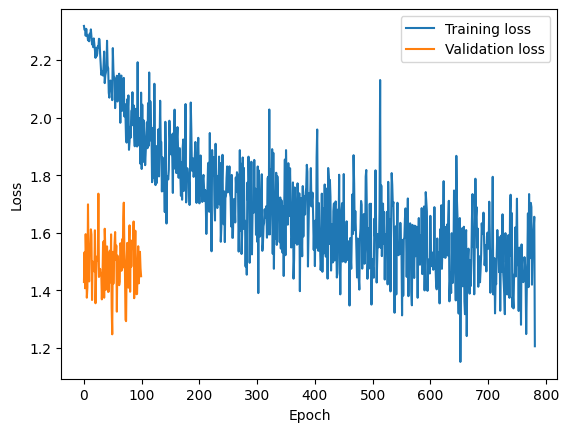

Final Test Accuracy: 46.48%


In [40]:
train_net(CNN(h_size=64))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    3456    |
|  net.0.bias  |    128     |
| net.3.weight |   18432    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 22682


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

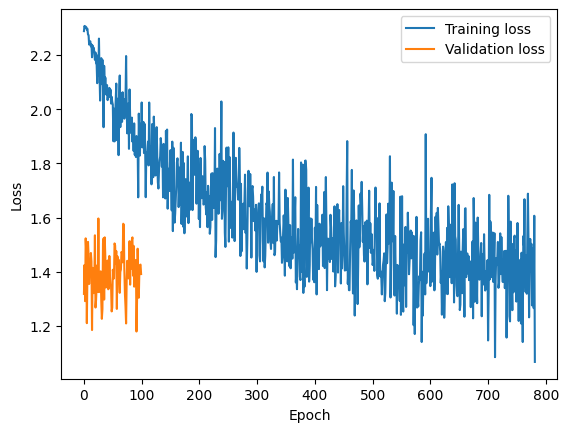

Final Test Accuracy: 50.83%


In [41]:
train_net(CNN(h_size=128))

In [20]:
for batch in trainloader:
    x = batch[0]
    break

In [15]:

x

tensor[64, 3, 32, 32] n=196608 x∈[-1.000, 1.000] μ=-0.048 σ=0.506

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    432     |
|   conv1.bias  |     16     |
|  conv2.weight |    576     |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 2050


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

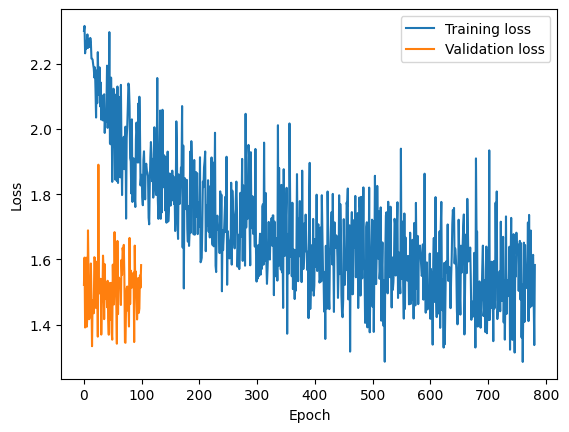

Final Test Accuracy: 44.86%


In [56]:
train_net(CNNSplit(h_size=16))

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

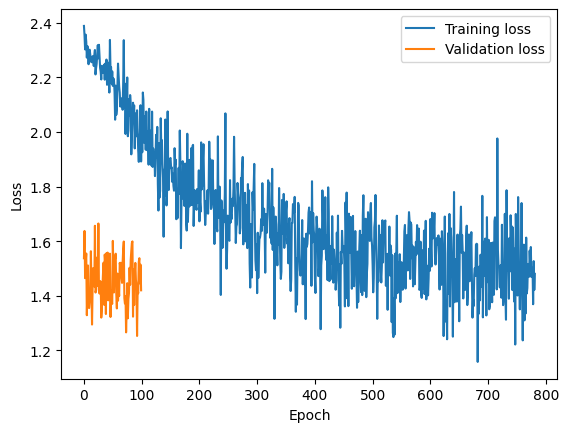

Final Test Accuracy: 47.19%


In [55]:
train_net(CNNSplit(h_size=32))

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    1728    |
|   conv1.bias  |     64     |
|  conv2.weight |    2304    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 5122


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

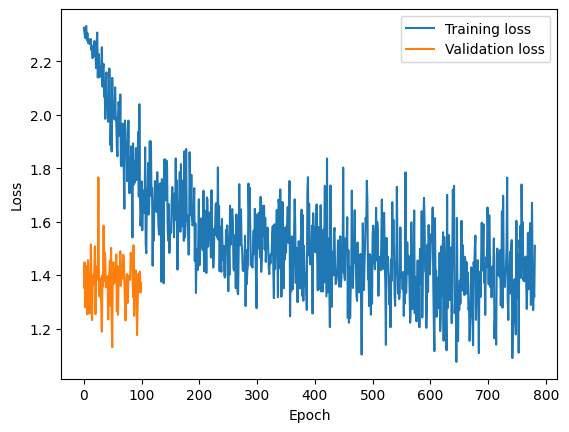

Final Test Accuracy: 49.79%


In [57]:
train_net(CNNSplit(h_size=64))

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    3456    |
|   conv1.bias  |    128     |
|  conv2.weight |    4608    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 9218


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

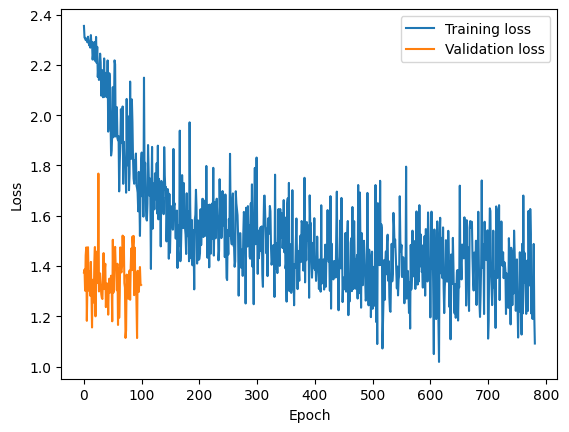

Final Test Accuracy: 51.25%


In [58]:
train_net(CNNSplit(h_size=128))

In [17]:
self = CNNSplit(h_size=128)

In [18]:
self.apply(orthogonal_weights_init)

CNNSplit(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (linear): Linear(in_features=100, out_features=10, bias=True)
)

In [56]:
for batch in trainloader:
    x = batch[0]
    break

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    1728    |
|   conv1.bias  |     64     |
|  conv2.weight |    2304    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 5122


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

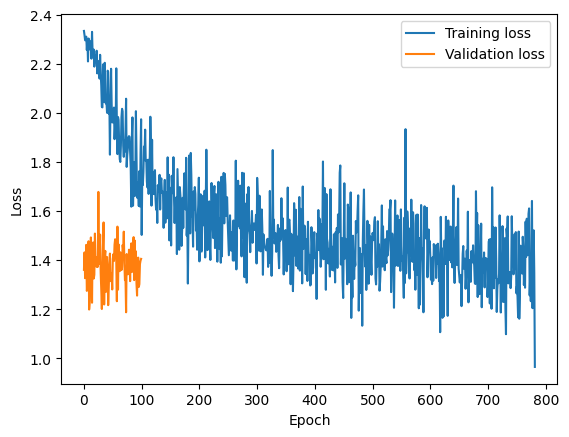

Final Test Accuracy: 49.89%


In [68]:
train_net(CNNSplit(h_size=64) )

Initial preact: tensor[64, 16, 30, 30] n=921600 x∈[-1.612, 1.323] μ=-0.025 σ=0.322 grad SplitBackward0
Initial preact: tensor[64, 16, 30, 30] n=921600 x∈[-1.581, 1.576] μ=0.004 σ=0.348 grad SplitBackward0
Initial preact: tensor[64, 16, 30, 30] n=921600 x∈[-1.948, 1.859] μ=-0.023 σ=0.343 grad SplitBackward0
Initial preact: tensor[64, 16, 30, 30] n=921600 x∈[-1.100, 1.070] μ=0.009 σ=0.289 grad SplitBackward0
after: tensor[64, 16, 30, 30] n=921600 x∈[-4.853, 4.081] μ=-0.041 σ=0.946 grad SplitBackward0
after: tensor[64, 16, 30, 30] n=921600 x∈[-4.537, 4.536] μ=-0.021 σ=0.969 grad SplitBackward0
after: tensor[64, 16, 30, 30] n=921600 x∈[-5.558, 5.543] μ=-0.006 σ=0.958 grad SplitBackward0
after: tensor[64, 16, 30, 30] n=921600 x∈[-3.929, 3.715] μ=0.002 σ=0.950 grad SplitBackward0
****************************************************************************************************
Initial preact: tensor[64, 4, 5, 5] n=6400 x∈[-3.934, 5.956] μ=0.261 σ=1.075 grad SplitBackward0
Initial preact: t

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

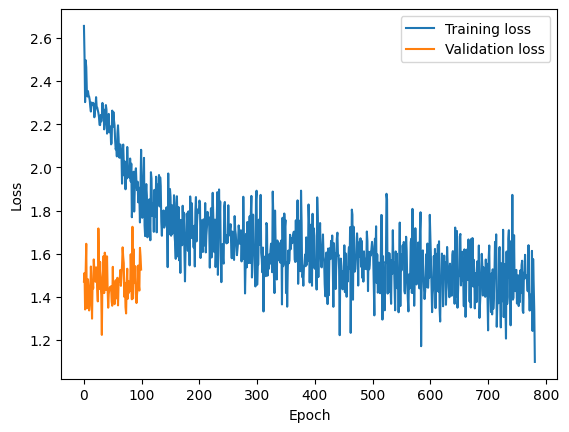

Final Test Accuracy: 45.79%


In [69]:
train_net(lsuv_init_2layer_split_cnn ( CNNSplit(h_size=64), x ) )

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    3456    |
|   conv1.bias  |    128     |
|  conv2.weight |    4608    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 9218


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

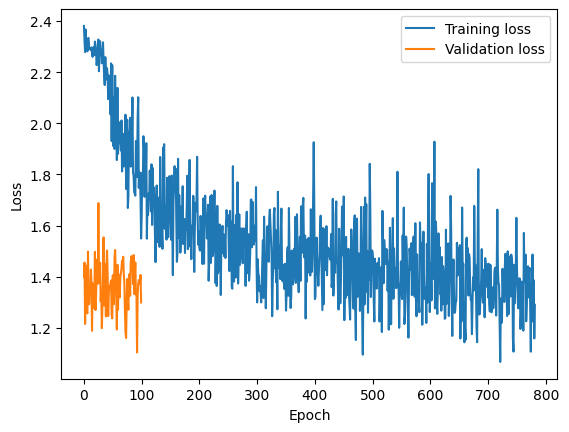

Final Test Accuracy: 50.56%


In [67]:
train_net(CNNSplit(h_size=128) )

Initial preact: tensor[64, 32, 30, 30] n=1843200 x∈[-1.389, 1.751] μ=-0.013 σ=0.308 grad SplitBackward0
Initial preact: tensor[64, 32, 30, 30] n=1843200 x∈[-1.454, 1.574] μ=-0.001 σ=0.340 grad SplitBackward0
Initial preact: tensor[64, 32, 30, 30] n=1843200 x∈[-1.544, 1.312] μ=0.029 σ=0.296 grad SplitBackward0
Initial preact: tensor[64, 32, 30, 30] n=1843200 x∈[-1.450, 1.534] μ=0.029 σ=0.312 grad SplitBackward0
after: tensor[64, 32, 30, 30] n=1843200 x∈[-4.554, 5.294] μ=6.825e-05 σ=0.919 grad SplitBackward0
after: tensor[64, 32, 30, 30] n=1843200 x∈[-4.091, 4.407] μ=0.011 σ=0.959 grad SplitBackward0
after: tensor[64, 32, 30, 30] n=1843200 x∈[-4.810, 4.377] μ=0.002 σ=0.948 grad SplitBackward0
after: tensor[64, 32, 30, 30] n=1843200 x∈[-4.569, 4.600] μ=0.018 σ=0.937 grad SplitBackward0
****************************************************************************************************
Initial preact: tensor[64, 4, 5, 5] n=6400 x∈[-3.667, 3.300] μ=-0.231 σ=0.996 grad SplitBackward0
Initial

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

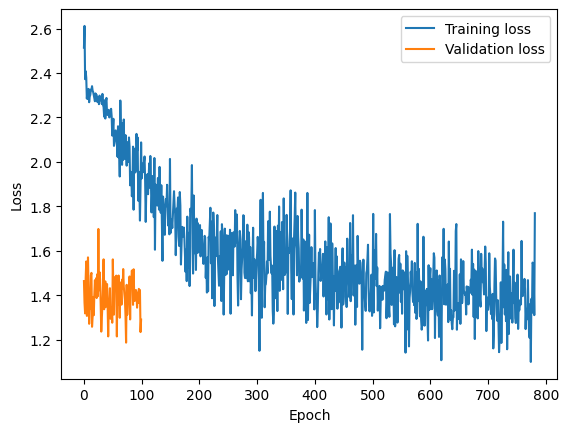

Final Test Accuracy: 49.12%


In [64]:
train_net(CNNSplit(h_size=128) )
train_net(lsuv_init_2layer_split_cnn ( CNNSplit(h_size=128), x ) )

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    6912    |
|   conv1.bias  |    256     |
|  conv2.weight |    9216    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 17410


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

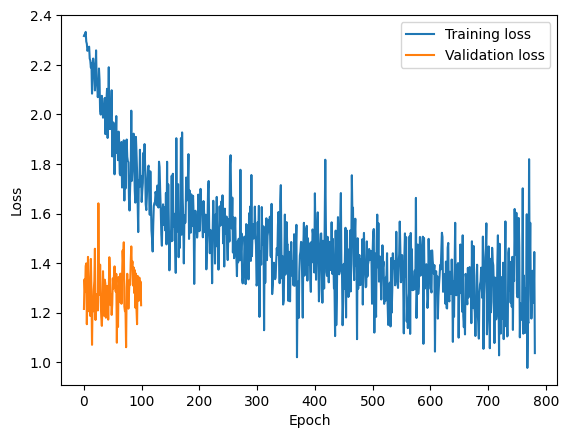

Final Test Accuracy: 53.71%
Initial preact: tensor[64, 64, 30, 30] n=3686400 x∈[-1.277, 1.412] μ=-0.025 σ=0.293 grad SplitBackward0
Initial preact: tensor[64, 64, 30, 30] n=3686400 x∈[-1.694, 1.442] μ=0.010 σ=0.317 grad SplitBackward0
Initial preact: tensor[64, 64, 30, 30] n=3686400 x∈[-1.960, 1.577] μ=-0.032 σ=0.336 grad SplitBackward0
Initial preact: tensor[64, 64, 30, 30] n=3686400 x∈[-1.789, 2.171] μ=0.025 σ=0.334 grad SplitBackward0
after: tensor[64, 64, 30, 30] n=3686400 x∈[-4.437, 4.482] μ=-0.006 σ=0.916 grad SplitBackward0
after: tensor[64, 64, 30, 30] n=3686400 x∈[-5.067, 4.832] μ=0.012 σ=0.941 grad SplitBackward0
after: tensor[64, 64, 30, 30] n=3686400 x∈[-5.486, 5.045] μ=0.004 σ=0.950 grad SplitBackward0
after: tensor[64, 64, 30, 30] n=3686400 x∈[-5.557, 6.312] μ=0.005 σ=0.943 grad SplitBackward0
****************************************************************************************************
Initial preact: tensor[64, 4, 5, 5] n=6400 x∈[-2.948, 5.956] μ=0.394 σ=1.101 gra

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

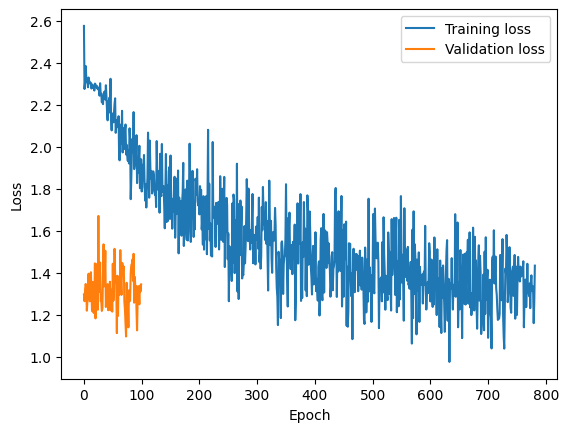

Final Test Accuracy: 52.09%


In [16]:
train_net(CNNSplit(h_size=256) )
train_net(lsuv_init_2layer_split_cnn ( CNNSplit(h_size=256), x ) )

In [ ]:
break

In [47]:
class CNNSplit2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16*2, 3)
        self.conv2 = nn.Conv2d(4*2, 16, 3)
        self.linear = nn.Linear(100, 10)

    def forward(self, x):
        p = self.conv1(x)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()

        a = nn.AvgPool2d(4)(10*a)

        p = self.conv2(a)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
        x = nn.Flatten()(10*a)
        
        x = self.linear(x)
        return x

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

In [73]:
count_parameters(CNNSplit2())

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


3074

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

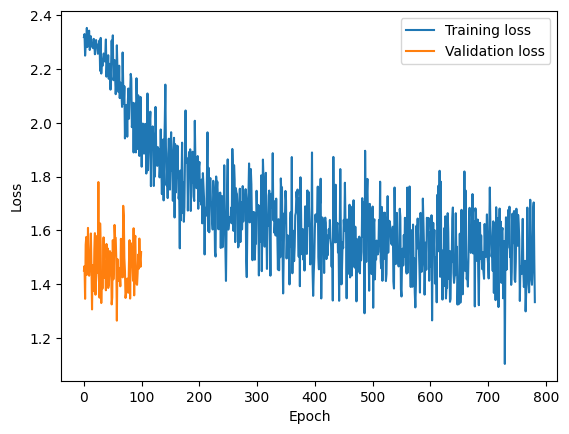

Final Test Accuracy: 46.95%


In [74]:
train_net(CNNSplit2())

In [95]:
class ConvSplitLayer(nn.Module):
    def __init__(self, in_c, out_c, multiplier=10., ks=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c*4, ks, padding=padding)
        self.multiplier = multiplier
        
    def forward(self, x):
        p = self.conv(x)
        p = p.chunk(4, dim=1)
        a = p[0].tanh() * p[1].sigmoid() * p[2].sin() * p[3].cos()
        
        return a * self.multiplier

In [98]:
layer = net = nn.Sequential(
            ConvSplitLayer(3, 16),
            ConvSplitLayer(16, 16),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),

            ConvSplitLayer(16, 32),
            ConvSplitLayer(32, 32),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            # ConvSplitLayer(32, 64),
            # ConvSplitLayer(64, 64),
            # nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(64),

            nn.Flatten(), )
layer(torch.rand(32, 3, 32, 32))

tensor[32, 2048] n=65536 x∈[-2.661, 8.003] μ=-1.863e-09 σ=1.000 grad ReshapeAliasBackward0

In [106]:
class BigCNNSplitAs(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ConvSplitLayer(3, 16),
            # ConvSplitLayer(16, 16),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),

            ConvSplitLayer(16, 32),
            # ConvSplitLayer(32, 32),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            # ConvSplitLayer(32, 64),
            # ConvSplitLayer(64, 64),
            # nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(64),

            nn.Flatten(), 

            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            # nn.Linear(512, 256),
            # nn.LeakyReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [100]:
count_parameters(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
| net.5.conv.weight |   36864    |
|  net.5.conv.bias  |    128     |
|    net.7.weight   |     32     |
|     net.7.bias    |     32     |
|    net.9.weight   |  1048576   |
|     net.9.bias    |    512     |
|   net.11.weight   |   131072   |
|    net.11.bias    |    256     |
|   net.13.weight   |    2560    |
|    net.13.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1249706


1249706

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
|    net.2.weight   |     16     |
|     net.2.bias    |     16     |
| net.3.conv.weight |   18432    |
|  net.3.conv.bias  |    128     |
|    net.5.weight   |     32     |
|     net.5.bias    |     32     |
|    net.7.weight   |  1048576   |
|     net.7.bias    |    512     |
|    net.9.weight   |    5120    |
|     net.9.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1074666


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

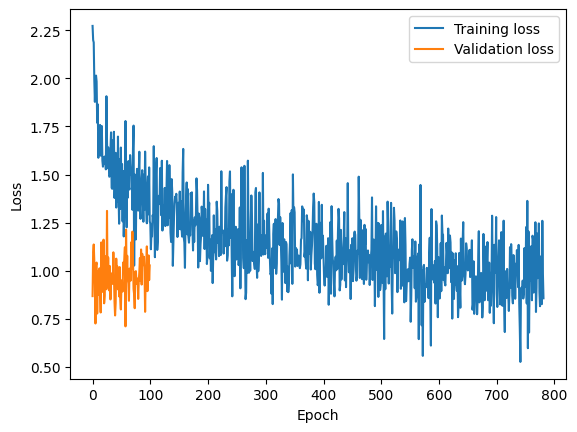

Final Test Accuracy: 65.53%


In [107]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
|    net.2.weight   |     16     |
|     net.2.bias    |     16     |
| net.3.conv.weight |   18432    |
|  net.3.conv.bias  |    128     |
|    net.5.weight   |     32     |
|     net.5.bias    |     32     |
|    net.7.weight   |  1048576   |
|     net.7.bias    |    512     |
|    net.9.weight   |   131072   |
|     net.9.bias    |    256     |
|   net.11.weight   |    2560    |
|    net.11.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1203434


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

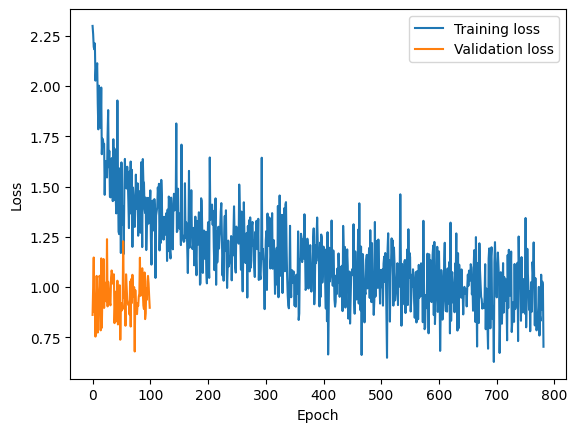

Final Test Accuracy: 66.65%


In [105]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
|    net.6.weight   |     32     |
|     net.6.bias    |     32     |
|    net.8.weight   |  1048576   |
|     net.8.bias    |    512     |
|   net.10.weight   |   131072   |
|    net.10.bias    |    256     |
|   net.12.weight   |    2560    |
|    net.12.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1212714


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

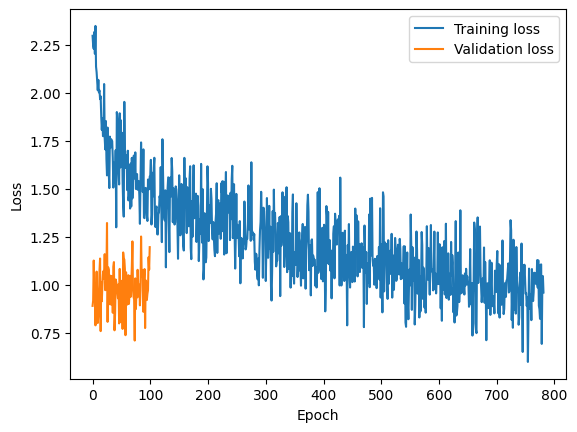

Final Test Accuracy: 64.64%


In [103]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
| net.5.conv.weight |   36864    |
|  net.5.conv.bias  |    128     |
|    net.7.weight   |     32     |
|     net.7.bias    |     32     |
|    net.9.weight   |  1048576   |
|     net.9.bias    |    512     |
|   net.11.weight   |   131072   |
|    net.11.bias    |    256     |
|   net.13.weight   |    2560    |
|    net.13.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1249706


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

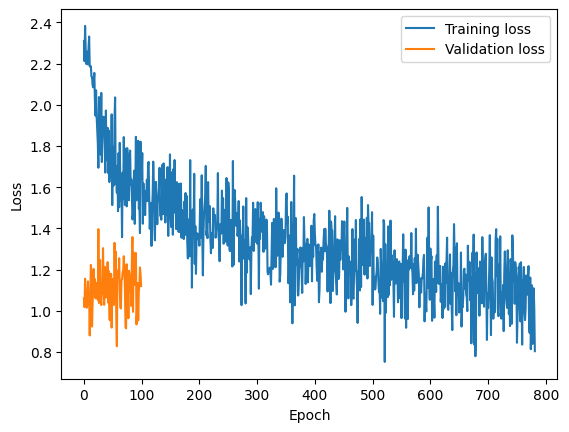

Final Test Accuracy: 61.08%


In [101]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
| net.5.conv.weight |   36864    |
|  net.5.conv.bias  |    128     |
|    net.7.weight   |     32     |
|     net.7.bias    |     32     |
| net.8.conv.weight |   73728    |
|  net.8.conv.bias  |    256     |
| net.9.conv.weight |   147456   |
|  net.9.conv.bias  |    256     |
|   net.11.weight   |     64     |
|    net.11.bias    |     64     |
|   net.13.weight   |   524288   |
|    net.13.bias    |    512     |
|   net.15.weight   |   131072   |
|    net.15.bias    |    256     |
|   net.17.weight   |    2560    |
|    net.17.bias    |     10     |
+-------------------+------------+
Total Trainable Para

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

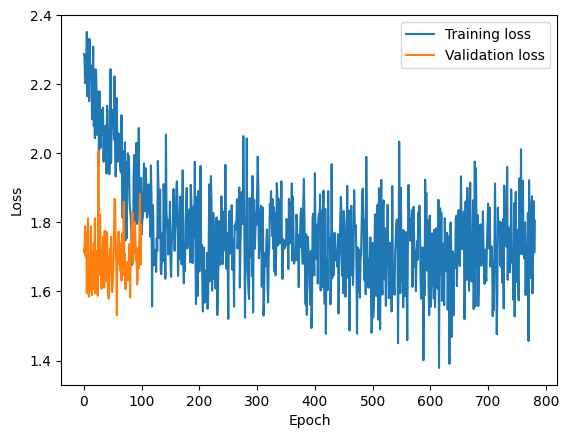

Final Test Accuracy: 36.49%


In [97]:
train_net(BigCNNSplitAs())

In [89]:
net(torch.rand(32, 3, 32, 32))

tensor[32, 1024] n=32768 x∈[-2.719, 7.554] μ=3.027e-09 σ=1.000 grad ReshapeAliasBackward0

In [ ]:
class BigCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [76]:
class BigCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  net.0.weight |    864     |
|   net.0.bias  |     32     |
|  net.2.weight |   18432    |
|   net.2.bias  |     64     |
|  net.5.weight |     64     |
|   net.5.bias  |     64     |
|  net.6.weight |   73728    |
|   net.6.bias  |    128     |
|  net.8.weight |   147456   |
|   net.8.bias  |    128     |
| net.11.weight |    128     |
|  net.11.bias  |    128     |
| net.12.weight |   294912   |
|  net.12.bias  |    256     |
| net.14.weight |   589824   |
|  net.14.bias  |    256     |
| net.17.weight |    256     |
|  net.17.bias  |    256     |
| net.19.weight |  4194304   |
|  net.19.bias  |    1024    |
| net.21.weight |   524288   |
|  net.21.bias  |    512     |
| net.23.weight |   131072   |
|  net.23.bias  |    256     |
| net.25.weight |    2560    |
|  net.25.bias  |     10     |
+---------------+------------+
Total Trainable Params: 5981002


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

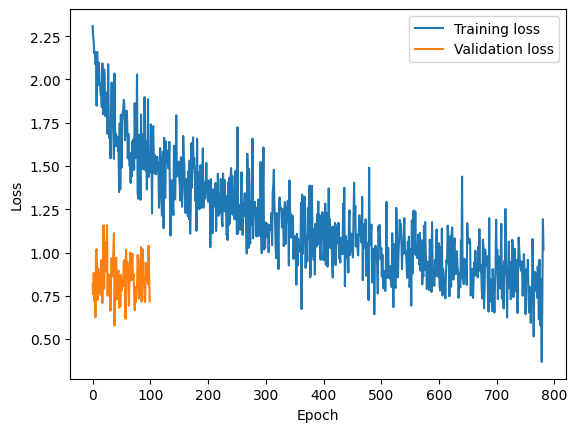

Final Test Accuracy: 70.98%


In [77]:
train_net(BigCNN())